In [ ]:

import os, warnings, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro
from scipy.stats import ttest_ind, mannwhitneyu


In [ ]:

df1= pd.read_csv("/datasets/telecom_dataset_us.csv", sep=",")
df2= pd.read_csv("/datasets/telecom_clients_us.csv", sep=",")




In [ ]:
df1.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [ ]:
df2.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


In [ ]:
# convertir a datetime

df1['date'] = pd.to_datetime(df1['date'])
df2['date_start'] = pd.to_datetime(df2['date_start'])

In [ ]:
# Comprobar asuentes 
display(df1.isna().mean().to_frame('missing_ratio').T)
display(df2.isna().mean().to_frame('missing_ratio').T)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
missing_ratio,0.0,0.0,0.0,0.002171,0.151608,0.0,0.0,0.0,0.0


,user_id,tariff_plan,date_start
missing_ratio,0.0,0.0,0.0


In [ ]:
# Conteo Duplicados


dup_df1 = pd.DataFrame({
    "duplicate_count": df1.apply(lambda x: x.duplicated().sum()),
    "duplicate_ratio": df1.apply(lambda x: x.duplicated().mean())
}).T

dup_df2 = pd.DataFrame({
    "duplicate_count": df2.apply(lambda x: x.duplicated().sum()),
    "duplicate_ratio": df2.apply(lambda x: x.duplicated().mean())
}).T

display(dup_df1)
display(dup_df2)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
duplicate_count,53595.000000,53783.000000,53900.000000,53899.000000,52809.000000,53900.000000,53400.000000,48529.000000,47862.000000
duplicate_ratio,0.994304,0.997792,0.999963,0.999944,0.979722,0.999963,0.990687,0.900319,0.887945


,user_id,tariff_plan,date_start
duplicate_count,0.0,729.000000,659.000000
duplicate_ratio,0.0,0.995902,0.900273


In [ ]:
def check_duplicates(df, key_cols=None, df_name="dataset"):
    print(f"\n Validación de duplicados en: {df_name}")
    

    # Revisar filas enteras repetidas
    full_dup = df.duplicated().sum()
    print(f"   - Filas duplicadas completas: {full_dup}")
    
    # Revisar columnas clave
    if key_cols:
        for col in key_cols:
            dup_count = df[col].duplicated().sum()
            if dup_count > 0:
                print(f"   - {col}: {dup_count} duplicados ")
            else:
                print(f"   - {col}: sin duplicados ")
    else:
        print("   - No se definieron columnas clave para validar.")


check_duplicates(df1, key_cols=["user_id"], df_name="telecom")
check_duplicates(df2,key_cols=["user_id"], df_name="clients")



 Validación de duplicados en: telecom
   - Filas duplicadas completas: 4900
   - user_id: 53595 duplicados 

 Validación de duplicados en: clients
   - Filas duplicadas completas: 0
   - user_id: sin duplicados 


In [ ]:
df1 = df1.drop_duplicates()

In [ ]:
# Número total de llamadas entrantes, perdidas y salientes por operador

# Total de llamadas entrantes y salientes
calls_by_operator = df1.groupby(["operator_id", "direction"])["calls_count"].sum().unstack(fill_value=0)

# Total de llamadas perdidas (solo entrantes)
missed_calls = df1[df1["direction"]=="in"].groupby("operator_id")["is_missed_call"].sum()

print(calls_by_operator.head())
print(missed_calls.head())

direction     in   out
operator_id           
879896.0      58   872
879898.0     104  7209
880020.0       7    38
880022.0       8   189
880026.0      24  2208
operator_id
879896.0    0
879898.0    0
880020.0    0
880022.0    0
880026.0    0
Name: is_missed_call, dtype: int64


In [ ]:
#Tiempo de espera promedio y máximo de cada operador



df1["wait_time"] = df1["total_call_duration"] - df1["call_duration"]

wait_stats = (
    df1[df1["direction"]=="in"]
    .groupby("operator_id")["wait_time"]
    .agg(["mean","max"])
    .rename(columns={"mean":"wait_avg","max":"wait_max"})
)

print(wait_stats.head())


              wait_avg  wait_max
operator_id                     
879896.0     27.333333       147
879898.0     29.473684       291
880020.0      7.714286        16
880022.0     14.000000        24
880026.0      7.944444        21


In [ ]:
# Duración de llamadas contestadas

# Una llamada contestada es cuando is_missed_call == 0.

answered_calls = (
    df1[(df1["direction"]=="in") & (df1["is_missed_call"]==0)]
    .groupby("operator_id")["call_duration"]
    .agg(["mean","max","count"])
    .rename(columns={"mean":"duration_avg","max":"duration_max","count":"answered_calls"})
)

print(answered_calls.head())

             duration_avg  duration_max  answered_calls
operator_id                                            
879896.0       267.428571          1422              21
879898.0       111.456140           388              57
880020.0        42.714286            63               7
880022.0        64.000000           140               8
880026.0        88.166667           556              18


In [ ]:
summary = (
    calls_by_operator
    .join(missed_calls, how="left", rsuffix="_missed")
    .join(wait_stats, how="left")
    .join(answered_calls, how="left")
    .fillna(0)
)

print(summary.head())

              in   out  is_missed_call   wait_avg  wait_max  duration_avg  \
operator_id                                                                 
879896.0      58   872             0.0  27.333333     147.0    267.428571   
879898.0     104  7209             0.0  29.473684     291.0    111.456140   
880020.0       7    38             0.0   7.714286      16.0     42.714286   
880022.0       8   189             0.0  14.000000      24.0     64.000000   
880026.0      24  2208             0.0   7.944444      21.0     88.166667   

             duration_max  answered_calls  
operator_id                                
879896.0           1422.0            21.0  
879898.0            388.0            57.0  
880020.0             63.0             7.0  
880022.0            140.0             8.0  
880026.0            556.0            18.0  


In [ ]:
summary["missed_rate"] = summary["is_missed_call"] / summary["in"]   # % llamadas entrantes perdidas
summary["out_rate"] = summary["out"] / (summary["in"] + summary["out"])  # % de llamadas que son salientes

In [ ]:
missed_q3 = np.percentile(summary["missed_rate"], 75)
wait_q3   = np.percentile(summary["wait_avg"], 75)
out_q1    = np.percentile(summary["out"], 25)

summary["ineficaz"] = (
    (summary["missed_rate"] > missed_q3) |
    (summary["wait_avg"] > wait_q3) |
    (summary["out"] < out_q1)
)

In [ ]:
ineficaces = summary[summary["ineficaz"]==True]
print(ineficaces.head())

              in   out  is_missed_call    wait_avg  wait_max  duration_avg  \
operator_id                                                                  
882476.0       3     0             0.0   31.666667      64.0     64.000000   
882478.0       3     1             0.0   38.000000      63.0     34.000000   
882680.0      99     0             3.0   37.000000     127.0    152.675000   
882684.0     613   661             4.0  190.520000     515.0   2841.369565   
882686.0     766  2884             5.0  165.750000     612.0   2285.206349   

             duration_max  answered_calls  missed_rate  out_rate  ineficaz  
operator_id                                                                 
882476.0            175.0             3.0     0.000000  0.000000      True  
882478.0             57.0             2.0     0.000000  0.250000      True  
882680.0            919.0            40.0     0.030303  0.000000      True  
882684.0           6593.0            46.0     0.006525  0.518838    

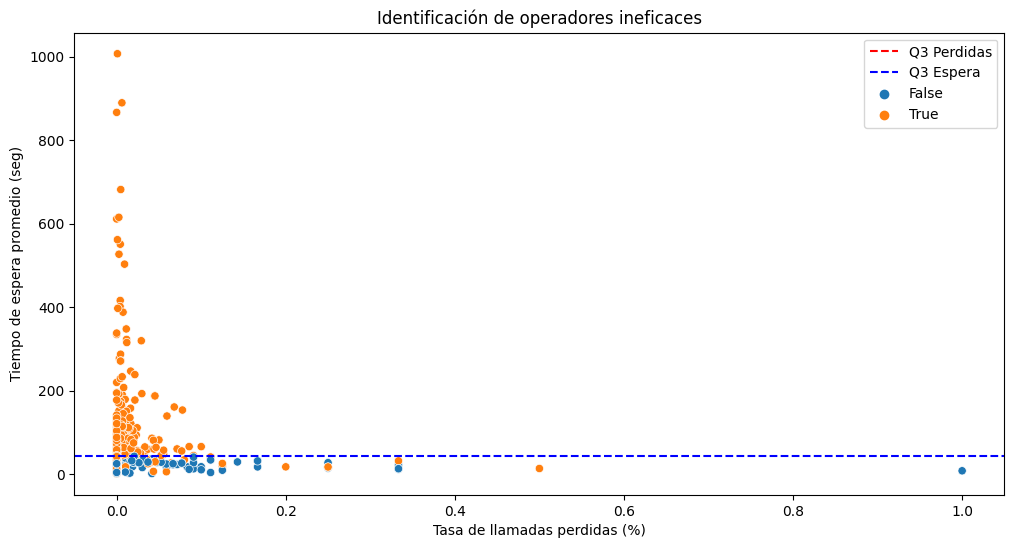

In [ ]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=summary, x="missed_rate", y="wait_avg", hue="ineficaz")
plt.axvline(missed_q3, color="red", linestyle="--", label="Q3 Perdidas")
plt.axhline(wait_q3, color="blue", linestyle="--", label="Q3 Espera")
plt.legend()
plt.title("Identificación de operadores ineficaces")
plt.xlabel("Tasa de llamadas perdidas (%)")
plt.ylabel("Tiempo de espera promedio (seg)")
plt.show()

In [ ]:
eficaces = summary[summary["ineficaz"]==False]
ineficaces = summary[summary["ineficaz"]==True]

In [ ]:
print(shapiro(eficaces["missed_rate"]))
print(shapiro(ineficaces["missed_rate"]))

ShapiroResult(statistic=nan, pvalue=1.0)
ShapiroResult(statistic=nan, pvalue=1.0)


In [ ]:
# tiempos espera
t_stat, p_val = ttest_ind(ineficaces["wait_avg"], eficaces["wait_avg"], equal_var=False)
print("Tiempo de espera - t-test:", p_val)


Tiempo de espera - t-test: 2.3617881243529096e-31


In [ ]:
# llamadas salientes 
t_stat, p_val = ttest_ind(ineficaces["out"], eficaces["out"], equal_var=False)
print("Llamadas salientes - t-test:", p_val)

Llamadas salientes - t-test: 0.8189235439882135


Si p < 0.05 → rechazas H₀ → hay diferencia significativa → respalda que los ineficaces son realmente distintos.

Si p ≥ 0.05 → no puedes rechazar H₀ → no hay evidencia suficiente para afirmar que se comporten diferente en esa métrica.